<a href="https://colab.research.google.com/github/rajveer-si/road-sign-recog/blob/main/road_sign_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [322]:
import torch
from torch import nn
from torchvision.datasets import GTSRB
import torchvision.transforms.v2 as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchmetrics import Accuracy
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

Device Agnostic Code

In [305]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading Data

In [306]:


train_data = GTSRB(
    root = 'data',
    transform = transform.Compose([transform.Resize((50, 50)), transform.ToTensor()]),
    download = True
)

test_data = GTSRB(
    root = 'data',
    split = 'test',
    transform = transform.Compose([transform.Resize((50, 50)), transform.ToTensor()]),
    download = True
)



Loading Data

In [307]:
train_data_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
test_data_loader = DataLoader(test_data, 16, shuffle = False)

Viewing a few images

In [308]:
img, label = next(iter(test_data_loader))
img.shape
plt.imshow(img)
plt.title(label)
plt.axis(False)

tensor(38)


In [309]:
from timeit import default_timer as timer

def time(start: int, end: int):
  return end - start

Downloading a custom accuracy function

In [310]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


Model Training Function

In [311]:
def train_model(
    model: nn.Module,
    dataLoader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    optimizer: torch.optim,
    accuracy_fn,
    epochs: int,
    device: torch.device
  ):

  start = timer()

  model.train()

  model.to(device)

  train_loss, train_acc = 0, 0

  for epoch in tqdm(range(epochs)):
    for batch, (X, y) in tqdm(enumerate(dataLoader)):
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()

      y_preds = model(X)

      loss = loss_fn(y_preds, y)
      train_loss += loss.item()
      train_acc += accuracy_fn(y, y_preds.argmax(dim = 1))

      loss.backward()
      optimizer.step()

    train_loss /= len(dataLoader)
    train_acc /= len(dataLoader)
    print(f"Train Loss: {train_loss} || Training Accuracy: {train_acc}")

  end = timer()
  return {
      'Training Loss': train_loss,
      'Training Accuracy': train_acc,
      'Time': time(start, end)
  }

# Model Class

Architecture uses ***average pooling*** first to reduce background noise, and then ***max pooling*** to highlight features of signs *(shape, letters, colors)*

In [313]:
class TrafficSignModel(nn.Module):
  def __init__(self, in_channels: int, hidden_units: int, out_channels: int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(
            in_channels = in_channels,
            out_channels = hidden_units * 2,
            kernel_size = 3
        ),
        nn.ReLU(),
        nn.Conv2d(
            hidden_units * 2,
            hidden_units * 2,
            kernel_size = 2
        ),
        nn.ReLU(),
        nn.Conv2d(
            hidden_units * 2,
            hidden_units,
            kernel_size = 2,
            padding = 3
        ),
        nn.ReLU(),
        nn.AvgPool2d(
            2
        )
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units * 2,
            kernel_size = 3
        ),
        nn.ReLU(),
        nn.Conv2d(
            hidden_units * 2,
            hidden_units * 2,
            kernel_size = 2
        ),
        nn.ReLU(),
        nn.Conv2d(
            hidden_units * 2,
            hidden_units,
            kernel_size = 2,
            padding = 3
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            3
        )
    )
    self.classify_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = hidden_units * 9 * 9,
            out_features = out_channels
        )
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classify_layer(x)
    return x

**Loss Function:** *Cross Entropy Loss*

**Optimizer:** *Stochastic Gradient Descent*, with L2 Regularization to prevent overfitting

In [314]:
model = TrafficSignModel(3, 32, 43)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, weight_decay = 0.0001)
from helper_functions import accuracy_fn

In [318]:
train_res = train_model(model, train_data_loader, loss_fn, optimizer, accuracy_fn, 3, device)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.42698149942686675 || Training Accuracy: 88.75750750750751


0it [00:00, ?it/s]

Train Loss: 0.1157397712890476 || Training Accuracy: 97.15916366817268


0it [00:00, ?it/s]

Train Loss: 0.05798233773991281 || Training Accuracy: 98.56435985805896


Model Evaluation

In [319]:
def eval_model(
    model: torch.nn.Module,
    testDataLoader: torch.utils.data.DataLoader,
    accuracy_fn,
    device
):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in testDataLoader:
      X, y = X.to(device), y.to(device)
      y_test_preds = model(X)
      test_loss += loss_fn(y_test_preds, y)

      test_acc += accuracy_fn(y, y_test_preds.argmax(dim = 1))

    test_loss /= len(testDataLoader)
    test_acc /= len(testDataLoader)

  return {
      'Test Loss': test_loss.item(),
      'Test Accuracy': test_acc
  }

In [337]:
res = eval_model(model, test_data_loader, accuracy_fn, device)
res

{'Test Loss': 0.3978523015975952, 'Test Accuracy': 92.50143843498275}

In [324]:
model.eval()
y_preds = []
y_actual = []
with torch.inference_mode():
  for X, y in test_data_loader:
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.argmax(y_logits, dim = 1)
    y_preds += [y_pred.to('cpu')]
    y_actual += [y.to('cpu')]

y_preds = torch.cat(y_preds)
y_actual = torch.cat(y_actual)



Displaying Confusion Matrix as a HeatMap

<Axes: >

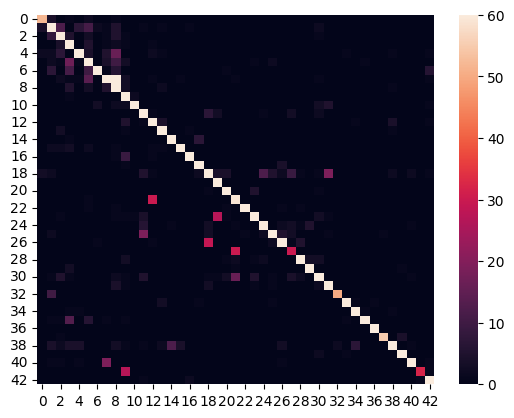

In [349]:
from seaborn import heatmap
disp = confusion_matrix(y_actual, y_preds)
heatmap(disp, robust = True)

F1 Score

In [346]:
from torchmetrics import F1Score
f1 = F1Score(task = "multiclass", num_classes = 43)
f1(y_preds, y_actual)

tensor(0.9251)

Model Save

In [341]:
torch.save(model.state_dict(), 'model.pt')